In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from Loader.ReadCSV import Reader


In [2]:
data = Reader.read_file(timeframe="H1").dropna()[["Open","High","Low","Close"]]
data.head()

,Open,High,Low,Close
datetime,,,,
2023-05-01 00:00:00,1.10106,1.10143,1.10045,1.10055
2023-05-01 01:00:00,1.10055,1.10084,1.10020,1.10040
2023-05-01 02:00:00,1.10037,1.10081,1.10007,1.10081
2023-05-01 03:00:00,1.10081,1.10140,1.10053,1.10140
2023-05-01 04:00:00,1.10143,1.10143,1.10032,1.10062


In [3]:
from feature_engineering.pipelines.AlphaPlusPipeline import ap_pipeline_x
data_features = ap_pipeline_x.fit_transform(data).dropna()
data_features.head()

,Open,High,Low,Close,bbh_50_2.0,bbl_50_2.0,bbh_15_1.5,bbl_15_1.5
datetime,,,,,,,,
2023-05-03 01:00:00,1.10173,1.10240,1.10128,1.10227,1.102948,1.095071,1.102602,1.096089
2023-05-03 02:00:00,1.10228,1.10258,1.10197,1.10253,1.103088,1.095011,1.103015,1.096445
2023-05-03 03:00:00,1.10252,1.10297,1.10251,1.10294,1.103267,1.094933,1.103246,1.097203
2023-05-03 04:00:00,1.10294,1.10294,1.10212,1.10216,1.103355,1.094899,1.102717,1.098775
2023-05-03 05:00:00,1.10217,1.10263,1.10182,1.10200,1.103396,1.094882,1.102678,1.099358


In [21]:
def df_to_X_y(df, window_size=5, max_periods = 10,sl=0.001,tp=0.001):
    df_as_np=df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_as_np)-window_size):
        row=[a for a in df_as_np[i:i+window_size]]
        X.append(row)

        open_price = df_as_np[i+window_size][3]
        sl_price = open_price*(1-sl)
        tp_price = open_price*(1+tp)
        hist = df_as_np[i+window_size:i+window_size+max_periods]
        val=[0]
        for i in hist:
            current_price=i[3]
            if current_price>tp_price:
                val=[1]
                break
            elif current_price<sl_price:
                break
        y.append(val)

    return np.array(X),np.array(y)
X,y=df_to_X_y(data_features,40,20)

In [22]:
y.sum()/len(y)

0.4798546895640687

In [23]:
def separate(X,y,pct_train=0.7,pct_val=0.1):
    pivot_train = int(len(X)*pct_train)
    pivot_val = int(len(X)*(pct_val+pct_train))
    X_train = X[:pivot_train]
    y_train = y[:pivot_train]
    X_val = X[pivot_train:pivot_val]
    y_val=y[pivot_train:pivot_val]
    X_test = X[pivot_val:]
    y_test=y[pivot_val:]
    return X_train,y_train,X_val,y_val,X_test,y_test

X_train,y_train,X_val,y_val,X_test,y_test = separate(X,y)

In [45]:
from tensorflow.keras.losses import BinaryCrossentropy,Hinge
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow as tf

from Models.transformer import transformer_model

cp = ModelCheckpoint('model1/',save_best_only=True)
input_shape = (X_train.shape[1], X_train.shape[2])
num_layers = 16
dff = 128
d_model = 8
num_heads = 8
dropout = 0.1
output_dim = 1
model = transformer_model(input_shape, num_layers, dff, d_model, num_heads, dropout, output_dim)

model.compile(optimizer=Adam(learning_rate=0.0001),loss=BinaryCrossentropy(), metrics=BinaryAccuracy())


In [46]:
history = model.fit(x=X_train,y=y_train,epochs=10,validation_data=(X_val,y_val),shuffle=False,callbacks=[cp])

Epoch 1/10
66/67 [============================>.] - ETA: 0s - loss: 0.7674 - binary_accuracy: 0.4697INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


67/67 [==============================] - 58s 470ms/step - loss: 0.7672 - binary_accuracy: 0.4710 - val_loss: 0.7127 - val_binary_accuracy: 0.4917
Epoch 2/10
67/67 [==============================] - 10s 152ms/step - loss: 0.7347 - binary_accuracy: 0.4710 - val_loss: 0.7326 - val_binary_accuracy: 0.4917
Epoch 3/10
67/67 [==============================] - 11s 160ms/step - loss: 0.7226 - binary_accuracy: 0.4710 - val_loss: 0.7143 - val_binary_accuracy: 0.4917
Epoch 4/10
67/67 [==============================] - ETA: 0s - loss: 0.7181 - binary_accuracy: 0.4710INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


67/67 [==============================] - 30s 458ms/step - loss: 0.7181 - binary_accuracy: 0.4710 - val_loss: 0.6985 - val_binary_accuracy: 0.4917
Epoch 5/10
67/67 [==============================] - ETA: 0s - loss: 0.7000 - binary_accuracy: 0.4710INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


67/67 [==============================] - 30s 448ms/step - loss: 0.7000 - binary_accuracy: 0.4710 - val_loss: 0.6929 - val_binary_accuracy: 0.4917
Epoch 6/10
67/67 [==============================] - ETA: 0s - loss: 0.6976 - binary_accuracy: 0.4710INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


67/67 [==============================] - 31s 465ms/step - loss: 0.6976 - binary_accuracy: 0.4710 - val_loss: 0.6920 - val_binary_accuracy: 0.4917
Epoch 7/10
67/67 [==============================] - 10s 156ms/step - loss: 0.7035 - binary_accuracy: 0.4710 - val_loss: 0.6921 - val_binary_accuracy: 0.4917
Epoch 8/10
67/67 [==============================] - 11s 157ms/step - loss: 0.7018 - binary_accuracy: 0.4710 - val_loss: 0.6923 - val_binary_accuracy: 0.4917
Epoch 9/10
67/67 [==============================] - 10s 155ms/step - loss: 0.7013 - binary_accuracy: 0.4710 - val_loss: 0.6923 - val_binary_accuracy: 0.4917
Epoch 10/10
67/67 [==============================] - 10s 154ms/step - loss: 0.6969 - binary_accuracy: 0.4710 - val_loss: 0.6923 - val_binary_accuracy: 0.4917


Text(0.5, 1.0, 'Model fitting performance')

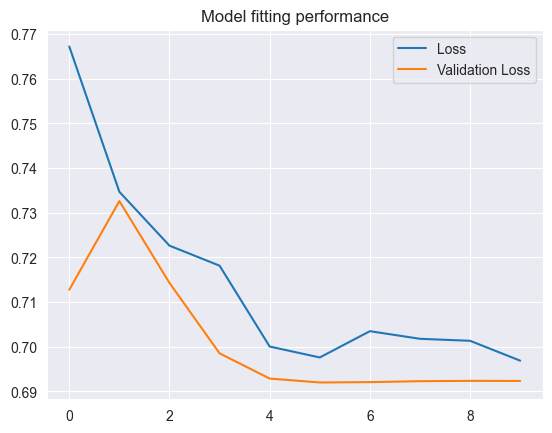

In [47]:
axes=plt.axes()
axes.plot(pd.DataFrame(model.history.history)['loss'], label='Loss')
axes.plot(pd.DataFrame(model.history.history)['val_loss'], label='Validation Loss')
axes.legend(loc=0)
axes.set_title('Model fitting performance')

In [48]:
model1=load_model('model1/')

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
def evaluate(y_pred,y_true):

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true,y_pred)

    class_labels = ['Nothing', 'Buy']
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()


19/19 [==============================] - 3s 58ms/step


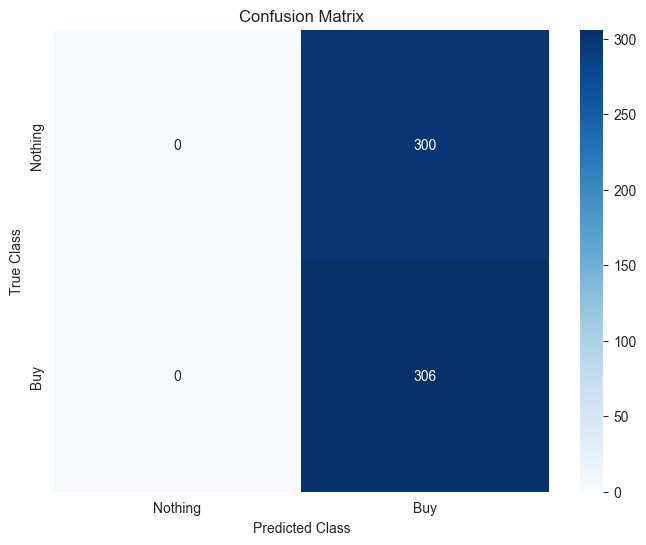

In [50]:
Y_test_predicted = model1.predict(X_test)
Y_test_true=(y_test.reshape(y_test.shape[0],y_test.shape[1]))
evaluate(Y_test_predicted,Y_test_true)


10/10 [==============================] - 1s 55ms/step


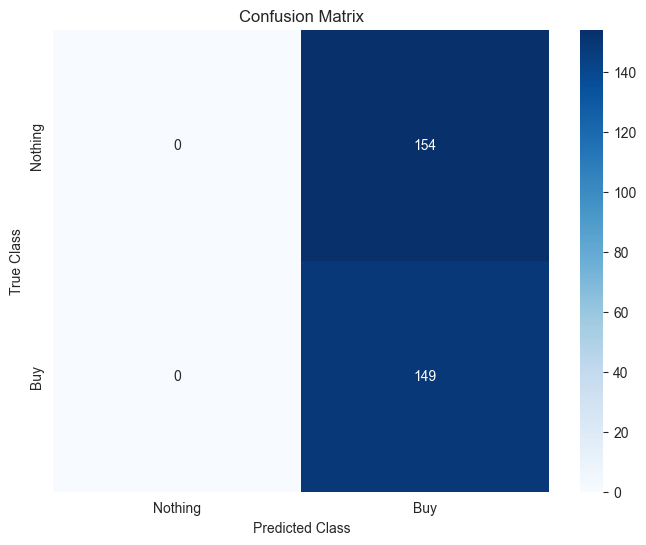

In [51]:
Y_val_predicted_best_model=model1.predict(X_val)
Y_val_true=(y_val.reshape(y_val.shape[0],y_val.shape[1]))
evaluate(Y_val_predicted_best_model,Y_val_true)

19/19 [==============================] - 1s 61ms/step


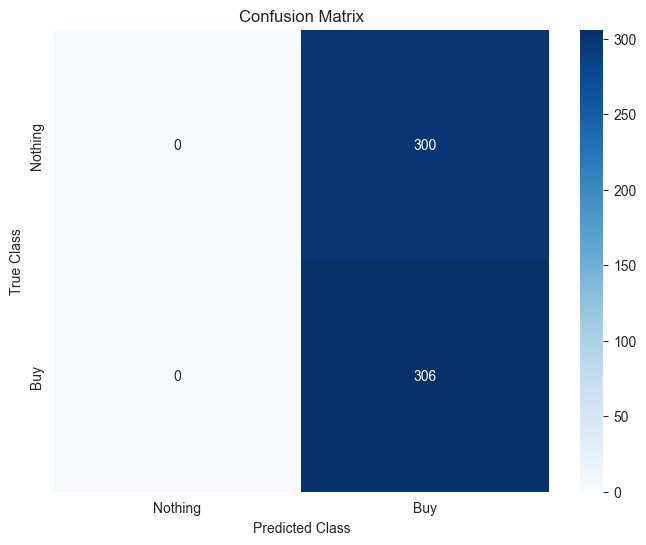

In [52]:
Y_predicted_best_model=model1.predict(X_test)
Y_true=(y_test.reshape(y_test.shape[0],1))
evaluate(Y_predicted_best_model,Y_true)

In [16]:
model1.save("cls_trns.keras")